# Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load modules

In [ ]:
import os
import cv2
import imghdr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load and clean image data

In [ ]:
base_dir = "/content/drive/Shared drives/Los Errescuer/Lightweight CNN/"
data_dir = os.path.join(base_dir, "wildfire_dataset")
classes = os.listdir(data_dir)
print(classes)

['forest', 'fire', 'smoke']


## Clean data

In [ ]:
# # Clean Data
# image_exts = ["jpg", "png", "jpeg", "bmp"]

# for image_class in os.listdir(data_dir):
#   for image in os.listdir(os.path.join(data_dir, image_class)):
#     image_path = os.path.join(data_dir, image_class, image)
#     try:
#       img = cv2.imread(image_path)
#       tip = imghdr.what(image_path)
#       if tip not in image_exts:
#         print(f"Incorrect extension for image: {image_path}")
#         os.remove(image_path)
#     except Exception as e:
#       print(f"Issue with image {image_path}")

## Load data as Tensorflow pipeline

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, class_names=classes, 
                                                   batch_size=16, image_size=(128,128),
                                                   shuffle=True, seed=128)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
# Batch of images
batch[0].shape

Found 781 files belonging to 3 classes.


(16, 128, 128, 3)

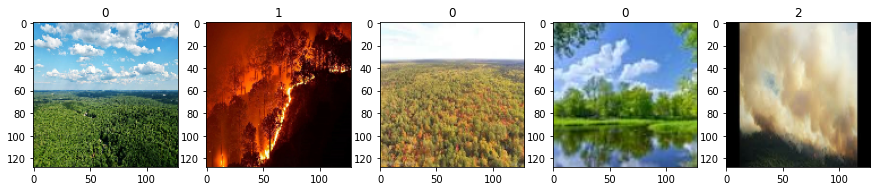

In [ ]:
# Display example images and labels
n = 5
fig, axes = plt.subplots(ncols=n, figsize=(15,8))
for idx, img in enumerate(batch[0][:n]):
  axes[idx].imshow(img.astype(int))
  axes[idx].set_title(batch[1][idx])

# Preprocess Data

## Scaling

In [ ]:
data = data.map(lambda x,y: (x/255, y))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
width = batch[0].shape[1]
height = batch[0].shape[2]
channels = batch[0].shape[3]

# Train-Validate Split

In [ ]:
train_size = int(len(data)*0.7)
validate_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

train = data.take(train_size)
val = data.skip(train_size).take(validate_size)
test = data.skip(train_size+validate_size).take(test_size)

In [ ]:
# Class distribution
for batch in train.as_numpy_iterator():
  x,y = batch
  print(np.unique(y, return_counts=True)[1])

[9 4 3]
[9 2 5]
[8 5 3]
[8 5 3]
[8 5 3]
[4 5 7]
[9 2 5]
[6 7 3]
[7 4 5]
[8 6 2]
[7 5 4]
[9 3 4]
[6 5 5]
[5 7 4]
[8 5 3]
[8 5 3]
[11  2  3]
[7 5 4]
[5 4 7]
[6 4 6]
[6 7 3]
[9 5 2]
[9 2 5]
[4 4 8]
[6 6 4]
[7 5 4]
[3 9 4]
[5 6 5]
[10  3  3]
[8 4 4]
[7 5 4]
[9 4 3]
[6 4 6]
[5 9 2]


# Convolutional Neural Network

## Build the network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, RandomZoom, RandomRotation, RandomFlip, RandomBrightness

In [ ]:
data_augment = Sequential()

data_augment.add(RandomZoom(0.1, input_shape=(width, height, channels)))
data_augment.add(RandomFlip("horizontal"))
# data_augment.add(RandomRotation(np.pi/6))
# data_augment.add(RandomBrightness(0.1))

In [ ]:
model = Sequential()

In [ ]:
model.add(data_augment)
model.add(Conv2D(16, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu')) # kernel_regularizer='l2'
model.add(Dense(len(classes), activation='softmax'))

In [ ]:
adam = tf.optimizers.Adam()
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer=adam, loss = cce, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)       

## Train

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
logdir = os.path.join(base_dir, "logs")
# model_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# %reload_ext tensorboard
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=logdir, monitor='val_accuracy', save_best_only=True)

mchk = EarlyStopping(monitor="val_loss", verbose = 1, patience = 8, restore_best_weights=True)
callback = [mchk]

In [ ]:
epochs = 40
history = model.fit(train, epochs = epochs, validation_data=val, callbacks = callback)

Epoch 1/40
34/34 [==============================] - 24s 657ms/step - loss: 0.5589 - accuracy: 0.7831 - val_loss: 0.3745 - val_accuracy: 0.8958
Epoch 2/40
34/34 [==============================] - 25s 705ms/step - loss: 0.3044 - accuracy: 0.8989 - val_loss: 0.3626 - val_accuracy: 0.8681
Epoch 3/40
34/34 [==============================] - 24s 665ms/step - loss: 0.3434 - accuracy: 0.8824 - val_loss: 0.6743 - val_accuracy: 0.7847
Epoch 4/40
34/34 [==============================] - 24s 656ms/step - loss: 0.3127 - accuracy: 0.8695 - val_loss: 0.2873 - val_accuracy: 0.9028
Epoch 5/40
34/34 [==============================] - 23s 642ms/step - loss: 0.2347 - accuracy: 0.9191 - val_loss: 0.2994 - val_accuracy: 0.9028
Epoch 6/40
34/34 [==============================] - 23s 636ms/step - loss: 0.2167 - accuracy: 0.9301 - val_loss: 0.2493 - val_accuracy: 0.9097
Epoch 7/40
34/34 [==============================] - 23s 636ms/step - loss: 0.1859 - accuracy: 0.9357 - val_loss: 0.2232 - val_accuracy: 0.9028


## Model Performance

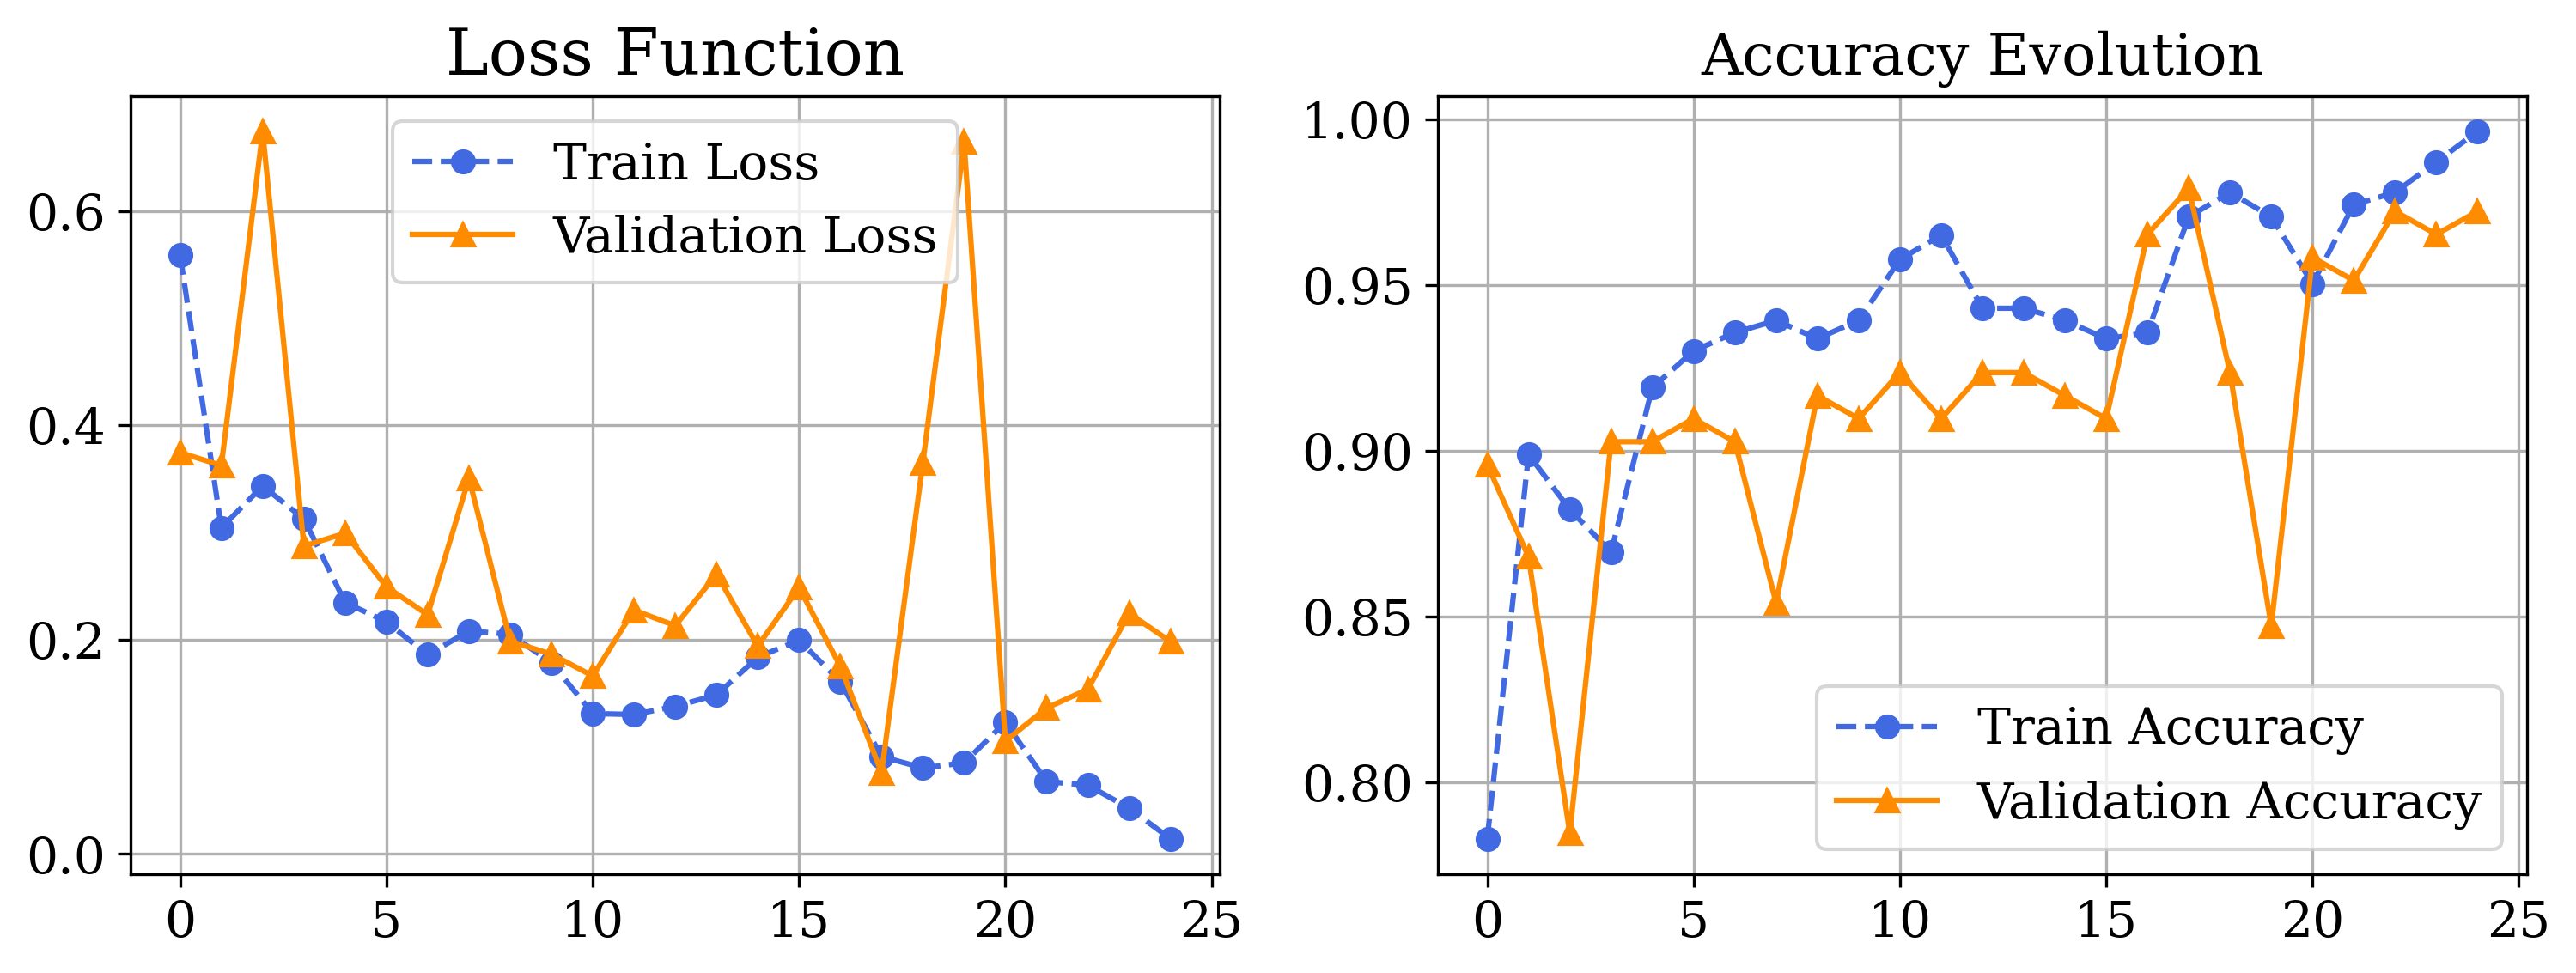

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
# plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 16

fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].plot(history.history["loss"], color="royalblue", label="Train Loss", marker="o", linestyle="--")
axes[0].plot(history.history["val_loss"], color="darkorange", label="Validation Loss", marker="^")
axes[0].set_title("Loss Function", fontsize=18)
axes[0].grid()
axes[0].legend()

axes[1].plot(history.history["accuracy"], color="royalblue", label="Train Accuracy", marker="o", linestyle="--")
axes[1].plot(history.history["val_accuracy"], color="darkorange", label="Validation Accuracy", marker="^")
axes[1].set_title("Accuracy Evolution")
axes[1].grid()
axes[1].legend()
plt.show()